# Описание проекта

Необходимо подготовить прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В нашем распоряжении данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

## Подготовка данных

In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, make_scorer
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.dummy import DummyRegressor

In [3]:
train = pd.read_csv('/datasets/gold_recovery_train.csv')
test = pd.read_csv('/datasets/gold_recovery_test.csv')
full = pd.read_csv('/datasets/gold_recovery_full.csv')

In [4]:
full.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


Получим информацию о тренировочном, тестовом и полном наборе данных.

In [5]:
for df in [train, test, full]:
    print('------------------------------------------------------------------------')
    df.info()

------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
date                                                  16860 non-null object
final.output.concentrate_ag                           16788 non-null float64
final.output.concentrate_pb                           16788 non-null float64
final.output.concentrate_sol                          16490 non-null float64
final.output.concentrate_au                           16789 non-null float64
final.output.recovery                                 15339 non-null float64
final.output.tail_ag                                  16794 non-null float64
final.output.tail_pb                                  16677 non-null float64
final.output.tail_sol                                 16715 non-null float64
final.output.tail_au                                  16794 non-null float64
primary_cleaner.input.sulfate                    

В тренировочном наборе представленно 87 столбцов и 16860 строк и почти во всех столбцах присутствуют пропуски. Необходимо разобраться какие данные нам понадобятся для построения модели, а какие можно откинуть.

В тестовом наборе данных всего 53 столбца и 5856 строк. Необходимо понять почему количество признаков в тестовых данных меньше, чем в тренировочных.

В полном наборе присутствуют 87 столбцов и 22716 строк.

### Расчет эффективности обогащения золота

Напишем функцию для расчета эффективности обогащения золота при флотации и сравним полученные данные с теми, которые записаны в тренировочной выборке, подсчитав МАЕ.

In [6]:
def recovery(row):
    C = row['rougher.output.concentrate_au'] #доля золота в концентрате после флотации
    F = row['rougher.input.feed_au'] #доля золота в сырье до флотации
    T = row['rougher.output.tail_au'] #доля золота в отвальных хвостах после флотации
    if F != 0:
        return C * (F - T) / (F * (C - T)) * 100
    else:
        return row['rougher.output.recovery']

In [7]:
rougher_out_recovery = train[train['rougher.output.recovery'] == train['rougher.output.recovery']].apply(recovery, axis=1)

In [8]:
print('MAE:', mean_absolute_error(
    train.loc[train['rougher.output.recovery'] == train['rougher.output.recovery'], 'rougher.output.recovery'],
    rougher_out_recovery)
     )

MAE: 9.444891926100695e-15


Полученное значение МАЕ близко к нулю, это говорит о том, что имеющиеся данные полностью соответствуют тем, которые мы получили при расчете эффекцивности обогащения по формуле.

### Изучение признаков отсутствующих в тестовой выборке

Выясним какие признаки отсутствуют в тестовой выборке и почему.

In [9]:
columns = list(train.columns[train.columns.isin(test.columns) != True])
#columns = train.columns.where(train.columns.isin(test.columns))
columns

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.ta

Как можно заметить из списка выше, в тестовой выборке отсутствуют признаки только с типом `output`, то есть с параметрами продукта на выходе из этапов обогащения и очистки золотосодержащей руды. Отсустсвуют они, потому что данные по этим признакам получаются только на реальных данных и по историческим данным их не построить. То есть в списке представлены онлайн-признаки.

Удалим строки, в которых есть пропуски в целевых колонках.

In [10]:
date_del = full.loc[full['final.output.recovery'].isnull() & full['rougher.output.recovery'].isnull()]['date']
train = train.dropna(subset=['final.output.recovery', 'rougher.output.recovery'], axis=0)
test = test.loc[test['date'].isin(date_del) == False]

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14149 entries, 0 to 16859
Data columns (total 87 columns):
date                                                  14149 non-null object
final.output.concentrate_ag                           14148 non-null float64
final.output.concentrate_pb                           14148 non-null float64
final.output.concentrate_sol                          13938 non-null float64
final.output.concentrate_au                           14149 non-null float64
final.output.recovery                                 14149 non-null float64
final.output.tail_ag                                  14149 non-null float64
final.output.tail_pb                                  14049 non-null float64
final.output.tail_sol                                 14144 non-null float64
final.output.tail_au                                  14149 non-null float64
primary_cleaner.input.sulfate                         14129 non-null float64
primary_cleaner.input.depressant             

In [12]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5434 entries, 0 to 5855
Data columns (total 53 columns):
date                                          5434 non-null object
primary_cleaner.input.sulfate                 5426 non-null float64
primary_cleaner.input.depressant              5427 non-null float64
primary_cleaner.input.feed_size               5434 non-null float64
primary_cleaner.input.xanthate                5427 non-null float64
primary_cleaner.state.floatbank8_a_air        5434 non-null float64
primary_cleaner.state.floatbank8_a_level      5434 non-null float64
primary_cleaner.state.floatbank8_b_air        5434 non-null float64
primary_cleaner.state.floatbank8_b_level      5434 non-null float64
primary_cleaner.state.floatbank8_c_air        5434 non-null float64
primary_cleaner.state.floatbank8_c_level      5434 non-null float64
primary_cleaner.state.floatbank8_d_air        5434 non-null float64
primary_cleaner.state.floatbank8_d_level      5434 non-null float64
rougher.in

Произведем предобработку данных, заполнив пропуски во всех выборках значениями элементов, стоящих перед пропущенными. Мы можем так сделать, потому что такие значения находятся рядом по временной шкале и не должны сильно отличаться.

In [13]:
train = train.ffill(axis=0)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14149 entries, 0 to 16859
Data columns (total 87 columns):
date                                                  14149 non-null object
final.output.concentrate_ag                           14149 non-null float64
final.output.concentrate_pb                           14149 non-null float64
final.output.concentrate_sol                          14149 non-null float64
final.output.concentrate_au                           14149 non-null float64
final.output.recovery                                 14149 non-null float64
final.output.tail_ag                                  14149 non-null float64
final.output.tail_pb                                  14149 non-null float64
final.output.tail_sol                                 14149 non-null float64
final.output.tail_au                                  14149 non-null float64
primary_cleaner.input.sulfate                         14149 non-null float64
primary_cleaner.input.depressant             

In [14]:
test = test.ffill(axis=0)
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5434 entries, 0 to 5855
Data columns (total 53 columns):
date                                          5434 non-null object
primary_cleaner.input.sulfate                 5434 non-null float64
primary_cleaner.input.depressant              5434 non-null float64
primary_cleaner.input.feed_size               5434 non-null float64
primary_cleaner.input.xanthate                5434 non-null float64
primary_cleaner.state.floatbank8_a_air        5434 non-null float64
primary_cleaner.state.floatbank8_a_level      5434 non-null float64
primary_cleaner.state.floatbank8_b_air        5434 non-null float64
primary_cleaner.state.floatbank8_b_level      5434 non-null float64
primary_cleaner.state.floatbank8_c_air        5434 non-null float64
primary_cleaner.state.floatbank8_c_level      5434 non-null float64
primary_cleaner.state.floatbank8_d_air        5434 non-null float64
primary_cleaner.state.floatbank8_d_level      5434 non-null float64
rougher.in

In [15]:
full = full.ffill(axis=0)
full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
date                                                  22716 non-null object
final.output.concentrate_ag                           22716 non-null float64
final.output.concentrate_pb                           22716 non-null float64
final.output.concentrate_sol                          22716 non-null float64
final.output.concentrate_au                           22716 non-null float64
final.output.recovery                                 22716 non-null float64
final.output.tail_ag                                  22716 non-null float64
final.output.tail_pb                                  22716 non-null float64
final.output.tail_sol                                 22716 non-null float64
final.output.tail_au                                  22716 non-null float64
primary_cleaner.input.sulfate                         22716 non-null float64
primary_cleaner.input.depressant             

В тестовых данных отсутствуют целевые признаки, а именно `rougher.output.recovery` и `final.output.recovery`, поэтому добавим их из исходных данных, чтобы в конце оценить качество модели.

In [16]:
test['rougher.output.recovery'] = full.query("date in @test.date")['rougher.output.recovery'].values
test['final.output.recovery'] = full.query("date in @test.date")['final.output.recovery'].values

Так как в тестовой выборке отсустствует ряд признаков, то чтобы создать модель, необходимо учитывать, чтобы количество признаков в тренировочной и тестовой выборках совпадали для корректности предсказаний. Для этого избавимся от части признаков в тренировочной выборке.

In [17]:
columns_test = list(train.columns[train.columns.isin(test.columns)])
train_new = train[columns_test]
train_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14149 entries, 0 to 16859
Data columns (total 55 columns):
date                                          14149 non-null object
final.output.recovery                         14149 non-null float64
primary_cleaner.input.sulfate                 14149 non-null float64
primary_cleaner.input.depressant              14149 non-null float64
primary_cleaner.input.feed_size               14149 non-null float64
primary_cleaner.input.xanthate                14149 non-null float64
primary_cleaner.state.floatbank8_a_air        14149 non-null float64
primary_cleaner.state.floatbank8_a_level      14149 non-null float64
primary_cleaner.state.floatbank8_b_air        14149 non-null float64
primary_cleaner.state.floatbank8_b_level      14149 non-null float64
primary_cleaner.state.floatbank8_c_air        14149 non-null float64
primary_cleaner.state.floatbank8_c_level      14149 non-null float64
primary_cleaner.state.floatbank8_d_air        14149 non-null flo

### Вывод

Данные представленны в трех выборках: тренировочной, тестовой и исходной(полной). Был произведен расчет средней абсолютной ошибки МАЕ и она оказалась близка к 0, что говорит о том, что представленные данные полностью соответствуют теоретическим расчетамы эффективности обогащения золотосодержащей руды. Так же была произведена предобработка данных, а именно были заполнены пропуски, в тестовую выборку были добавлены целевые признаки и в тренировочной выборке оставили только те признаки, которые есть в тестовой.

## Анализ данных

### Исследование распределений концентрации металлов

Посмотрим как меняется концентрация металов на различных этапах очистки.

In [18]:
def plots_conc(df):
    for elem in ['ag', 'pb', 'sol', 'au']:
        ax = df.plot(
            y='final.output.concentrate_'+elem, kind='hist', histtype='step', bins=100,
            grid=True, figsize=(12, 9), label='Финал')
        df.plot(
            y='primary_cleaner.output.concentrate_'+elem, kind='hist', histtype='step', bins=100,
            grid=True, ax=ax, label='Первичная очистка')
        df.plot(
            y='rougher.output.concentrate_'+elem, kind='hist', histtype='step', bins=100,
            grid=True, ax=ax, color='red', label='Флотация')
        plt.title('Концентрация ' + elem)
        plt.show()

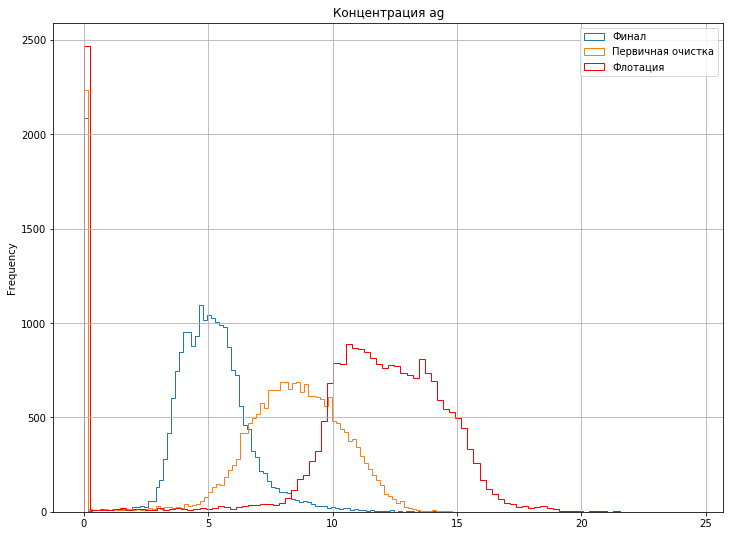

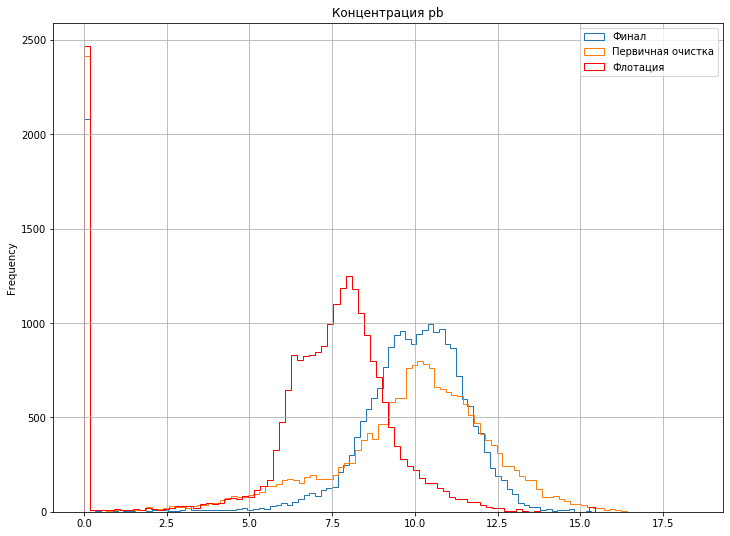

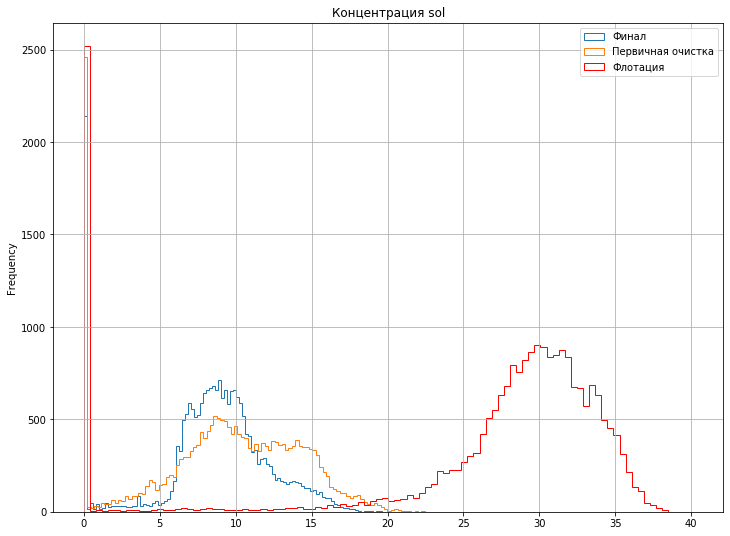

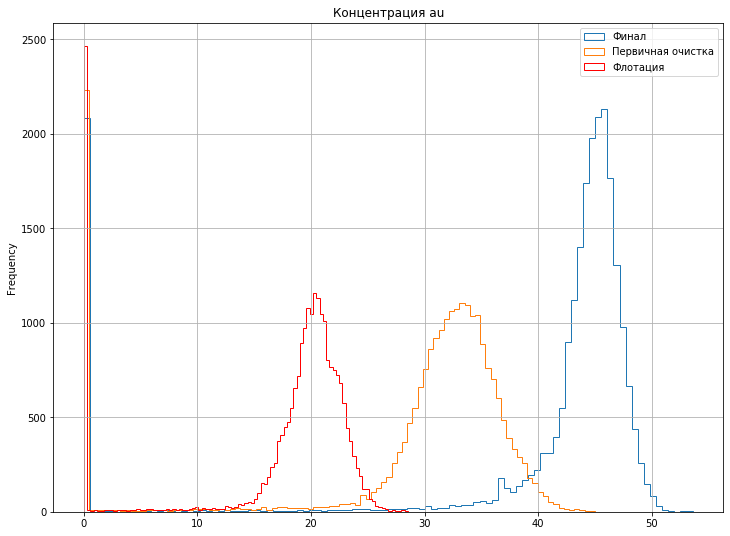

In [19]:
plots_conc(full)

По гистограммам можно увидеть, что концентрации различных металлов при прохождении через этапы очистки руды ведут себя по разному.

    - Концентрация Ag имеет явную нисходящую тенденцию от этапа флотации до финального этапа
    - Концентрация Pb остается почти не изменной
    - Концентрация Sol в свою очередь резко снижается на этапе первичной очистки и после остается почти неизменной
    - Концентрация же Золота повышается от этапа к этапу.

Кроме того для всех металлов и на всех этапах есть множественные выбросы в районе концентрации равной нулю. Это может быть связано с ошибкой в расчетах приборов при вычислении концентрации продукта.

В остальном же распределения всех металлов по всем этапам нормальное, что говорит о корректности имеющихся данных.

### Сравнение распределений размеров гранул сырья

Сравним распределения размеров гранул сырья на обучающей и тестовой выборках.

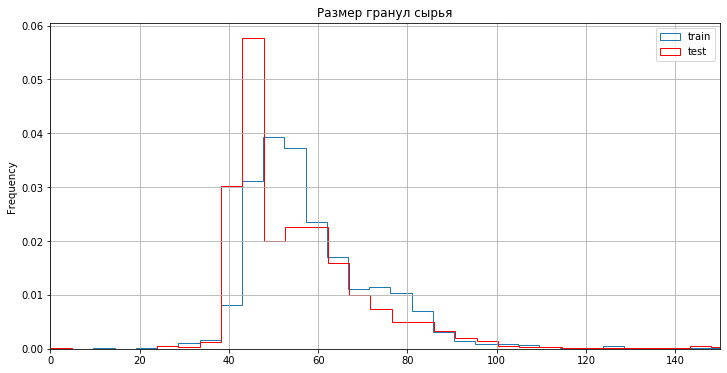

In [21]:
ax = train_new.plot(y='rougher.input.feed_size', kind='hist',
                    histtype='step', density=True, bins=100,
                    grid=True, figsize=(12, 6), label='train')
test.plot(y='rougher.input.feed_size', kind='hist', histtype='step',
          density=True, bins=100, grid=True, ax=ax,
          label='test', color='red')
plt.title('Размер гранул сырья')
plt.xlim([0, 150])
plt.show()

Распределения размеров гранул сырья на тестовой и тренировочных выборках нормальные и почти не отличаются друг от друга.

### Исследование суммарной концентрации металлов

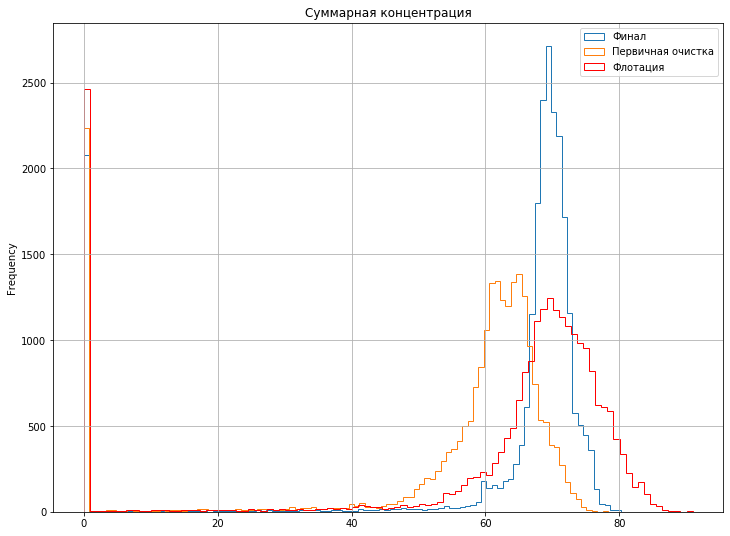

In [22]:
ag = '.output.concentrate_ag'
pb = '.output.concentrate_pb'
sol = '.output.concentrate_sol'
au = '.output.concentrate_au'
conc_sum = pd.DataFrame(columns=['rougher', 'primary_cleaner', 'final'])
for n in ['rougher', 'primary_cleaner', 'final']:
    conc_sum[n] = full[n + ag] + full[n + pb] + full[n + sol] + full[n + au]

ax = conc_sum.plot(y='final', kind='hist', histtype='step', bins=100, grid=True, figsize=(12, 9), label='Финал')
conc_sum.plot(y='primary_cleaner', kind='hist', histtype='step', bins=100, grid=True, ax=ax, label='Первичная очистка')
conc_sum.plot(y='rougher', kind='hist', histtype='step', bins=100, grid=True, ax=ax, color='red', label='Флотация')
plt.title('Суммарная концентрация')
plt.show()

Распределения суммарных концентраций по этапам имеют нормальный характер. Как и в гистограммах концентраций присутствуют выбросы в районе нуля, что может быть связано с ошибкой приборов и/или расчетов. Удалим выбросы.

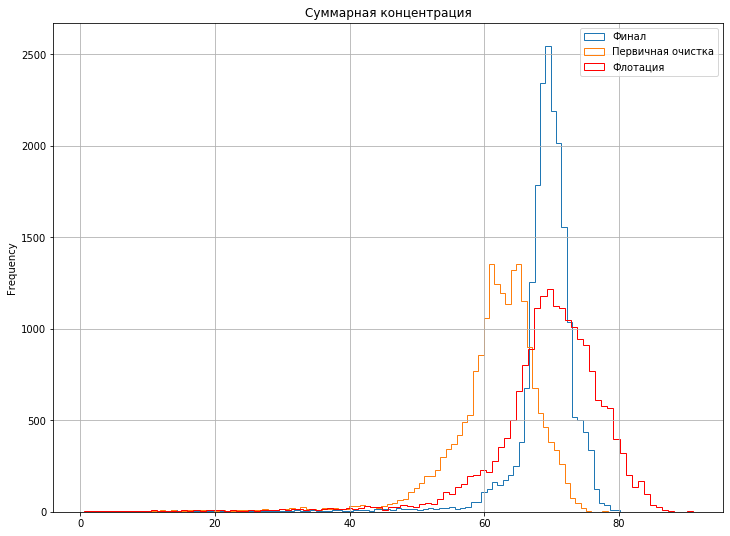

In [23]:
conc_sum_new = conc_sum.query('(final > 0.5) and (primary_cleaner > 0.5) and (rougher > 0.5)')
ax = conc_sum_new.plot(y='final', kind='hist', histtype='step', bins=100, grid=True, figsize=(12, 9), label='Финал')
conc_sum_new.plot(y='primary_cleaner', kind='hist', histtype='step', bins=100, grid=True, ax=ax, label='Первичная очистка')
conc_sum_new.plot(y='rougher', kind='hist', histtype='step', bins=100, grid=True, ax=ax, color='red', label='Флотация')
plt.title('Суммарная концентрация')
plt.show()

Удаление выбросов из тренировочной и тестовой выборок. Удалять будем по времени измерения.

In [24]:
test.shape

(5434, 55)

In [25]:
index_del = conc_sum.query('(final > 0.5) and (primary_cleaner > 0.5) and (rougher > 0.5)').index
date_del = full.loc[full.index.isin(index_del)]['date']
train_new = train_new.loc[train_new['date'].isin(date_del)]
test = test.loc[test['date'].isin(date_del)]
test.shape

(5232, 55)

Исследуем имеющиеся признаки на мультиколлинеарность и отсеим те, у который корреляции будут больше 85%.

In [26]:
train_new.corr()

,final.output.recovery,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
final.output.recovery,1.000000,0.387696,0.153230,0.063632,0.228686,0.164572,0.048617,0.182135,0.041923,0.170274,...,0.232027,0.056981,0.192716,-0.109026,0.116552,0.029891,0.085689,0.047039,-0.015535,-0.051609
primary_cleaner.input.sulfate,0.387696,1.000000,0.482760,0.159131,0.265594,0.030800,-0.046685,0.054223,-0.042548,0.051433,...,0.085533,0.023842,0.106062,-0.061111,-0.004881,-0.040553,0.004463,-0.035560,-0.109835,-0.153506
primary_cleaner.input.depressant,0.153230,0.482760,1.000000,0.169035,0.276970,-0.149763,0.121206,-0.110240,0.137093,-0.123227,...,-0.235346,-0.165530,-0.133068,-0.288016,-0.262042,-0.164564,-0.218046,-0.156878,-0.167633,-0.131402
primary_cleaner.input.feed_size,0.063632,0.159131,0.169035,1.000000,-0.004874,-0.128819,0.080259,-0.128196,0.083347,-0.153819,...,-0.329768,0.111123,-0.252157,0.022349,-0.227850,0.125880,-0.212746,0.128223,0.150701,0.063868
primary_cleaner.input.xanthate,0.228686,0.265594,0.276970,-0.004874,1.000000,0.067563,0.024732,0.097669,0.021219,0.061976,...,0.033455,-0.215548,0.009160,-0.331534,-0.082264,-0.205010,-0.096181,-0.203699,-0.222071,-0.080971
primary_cleaner.state.floatbank8_a_air,0.164572,0.030800,-0.149763,-0.128819,0.067563,1.000000,0.159626,0.944750,0.169392,0.934217,...,0.542972,0.331114,0.514967,0.219727,0.547463,0.259488,0.493946,0.251556,0.305451,0.054051
primary_cleaner.state.floatbank8_a_level,0.048617,-0.046685,0.121206,0.080259,0.024732,0.159626,1.000000,0.119592,0.977623,0.150804,...,-0.052862,0.050930,0.085583,-0.044711,0.001763,0.104934,0.063462,0.081126,0.171686,0.188921
primary_cleaner.state.floatbank8_b_air,0.182135,0.054223,-0.110240,-0.128196,0.097669,0.944750,0.119592,1.000000,0.144668,0.940144,...,0.524584,0.344053,0.512096,0.194622,0.547338,0.266681,0.480013,0.259320,0.306476,0.032635
primary_cleaner.state.floatbank8_b_level,0.041923,-0.042548,0.137093,0.083347,0.021219,0.169392,0.977623,0.144668,1.000000,0.161190,...,-0.077470,0.062270,0.071120,-0.034587,-0.018430,0.118909,0.040806,0.094091,0.166693,0.194177
primary_cleaner.state.floatbank8_c_air,0.170274,0.051433,-0.123227,-0.153819,0.061976,0.934217,0.150804,0.940144,0.161190,1.000000,...,0.582852,0.321067,0.581963,0.209011,0.582722,0.225148,0.545650,0.226735,0.269712,0.040620


In [27]:
def features_choice(data, name_cols, col):
    k = 0
    new = name_cols
    for i in list(name_cols):
        if (abs(data[col].corr(data[i])) > 0.85) and (col != i):
            k += 1
            print('Корреляция', col, '______', i, '=', data[col].corr(data[i]))
            cols_drop.append(col)
            new = name_cols.drop(col)
            return new
    return new

In [28]:
train_new_col = train_new.drop(['date'], axis=1)
print('Количество признаков до:', len(train_new_col.columns))
k = 0
cols_drop = []
name_cols = train_new_col.columns
for col in list(train_new_col.columns):
    if (col != 'final.output.recovery') and (col != 'rougher.output.recovery'):
        name_cols = features_choice(train_new_col, name_cols, col)

name_cols

Количество признаков до: 54
Корреляция primary_cleaner.state.floatbank8_a_air ______ primary_cleaner.state.floatbank8_b_air = 0.9447497075406712
Корреляция primary_cleaner.state.floatbank8_a_level ______ primary_cleaner.state.floatbank8_b_level = 0.9776228372304803
Корреляция primary_cleaner.state.floatbank8_b_air ______ primary_cleaner.state.floatbank8_c_air = 0.9401440095663035
Корреляция primary_cleaner.state.floatbank8_b_level ______ primary_cleaner.state.floatbank8_c_level = 0.9673596077063681
Корреляция rougher.input.floatbank10_xanthate ______ rougher.input.floatbank11_xanthate = 0.8935613807910262
Корреляция rougher.state.floatbank10_b_air ______ rougher.state.floatbank10_c_air = 0.9345541349477985
Корреляция rougher.state.floatbank10_b_level ______ rougher.state.floatbank10_c_level = 0.9876282997462964
Корреляция rougher.state.floatbank10_c_air ______ rougher.state.floatbank10_d_air = 0.9101531681709231
Корреляция rougher.state.floatbank10_c_level ______ rougher.state.floatban

Index(['final.output.recovery', 'primary_cleaner.input.sulfate',
       'primary_cleaner.input.depressant', 'primary_cleaner.input.feed_size',
       'primary_cleaner.input.xanthate',
       'primary_cleaner.state.floatbank8_c_air',
       'primary_cleaner.state.floatbank8_c_level',
       'primary_cleaner.state.floatbank8_d_air',
       'primary_cleaner.state.floatbank8_d_level', 'rougher.input.feed_ag',
       'rougher.input.feed_pb', 'rougher.input.feed_rate',
       'rougher.input.feed_size', 'rougher.input.feed_sol',
       'rougher.input.feed_au', 'rougher.input.floatbank10_sulfate',
       'rougher.input.floatbank11_sulfate',
       'rougher.input.floatbank11_xanthate', 'rougher.output.recovery',
       'rougher.state.floatbank10_a_air', 'rougher.state.floatbank10_a_level',
       'rougher.state.floatbank10_f_air', 'rougher.state.floatbank10_f_level',
       'secondary_cleaner.state.floatbank2_b_air',
       'secondary_cleaner.state.floatbank2_b_level',
       'secondary_cleaner

In [29]:
train_new_col = train_new[name_cols]
test_new = test[name_cols]
train_new_col.shape

(13600, 36)

Осталось 36 колонок, из которых 2 признака целевые.

### Вывод 

На этом этапе были проанализированы данные исходной, тренировочной и тестовой выборок. Концентрация золота растет от этапа к этапу, чего нельзя сказать об остальных металлах. Размеры гранул сырья в тренировочной и тестовой выбрках распределены одинаковым образом. Найденные аномалии и выбросы в распределении концентрации металлов и оценки качества очистки были удалены.

## Модель

Напишем функции для подсчета sMAPE.

In [30]:
def smape(y, y1):
    return (1 / len(y) * sum(abs(y - y1) / (abs(y) + abs(y1)) * 2 * 100))

def smape_fin(target, pred):
    target = np.array(target)
    pred = np.array(pred)
    return 0.25 * smape(target[:, 0], pred[:, 0]) + 0.75 * smape(target[:, 1], pred[:, 1])

Напишем скорер для кроссвалидации.

In [31]:
smape_score = make_scorer(smape_fin, greater_is_better=False)

Выделим признаки и целевые признаки для тренировочной и тестовой выборок.

In [32]:
target_train = train_new_col[['rougher.output.recovery', 'final.output.recovery']]
features_train = train_new_col.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)
target_test = test_new[['rougher.output.recovery', 'final.output.recovery']]
features_test = test_new.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)

In [33]:
features_test.shape

(5232, 34)

### Линейная регрессия

In [34]:
lin = LinearRegression()
final_score = cross_val_score(lin, features_train, target_train, cv=3, scoring=smape_score).mean()
print('sMAPE линейной регрессии: {:.3f}'.format(final_score))

sMAPE линейной регрессии: -12.391


### Случайный лес

In [35]:
smape_best = 100
depth_best = 0
for depth in range(6, 10):
    forest = RandomForestRegressor(random_state=123, n_estimators=10, max_depth=depth)
    final_score = (cross_val_score(forest, features_train, target_train, cv=3, scoring=smape_score).mean())
    if abs(final_score) < abs(smape_best):
        smape_best = final_score
        depth_best = depth
            
print('Глубина: ', depth_best)
print('sMAPE: {:.3f}'.format(smape_best))

Глубина:  6
sMAPE: -10.266


In [36]:
smape_best = 100
est_best = 0
for est in range(10, 50, 10):
    forest = RandomForestRegressor(random_state=123, n_estimators=est, max_depth=depth_best)
    final_score = (cross_val_score(forest, features_train, target_train, cv=3, scoring=smape_score).mean())
    if abs(final_score) < abs(smape_best):
        smape_best = final_score
        est_best = est

print('Количество деревьев:', est_best)
print('sMAPE: {:.3f}'.format(smape_best))

Количество деревьев: 40
sMAPE: -9.928


In [37]:
print('Случайный лес')
print('Глубина:', depth_best)
print('Количество деревьев:', est_best)
print('sMAPE: {:.3f}'.format(smape_best))

Случайный лес
Глубина: 6
Количество деревьев: 40
sMAPE: -9.928


### Градиентный бустинг

In [38]:
smape_best = 100
depth_best = 0
for depth in range(3, 6):
    gb = GradientBoostingRegressor(loss='lad', random_state=123, n_estimators=10, max_depth=depth, learning_rate=0.01)
    final_score = cross_val_score(gb, features_train, target_train.iloc[:, 1], cv=3,
                                  scoring=make_scorer(smape, greater_is_better=False)).mean()
    rougher_score = cross_val_score(gb, features_train, target_train.iloc[:, 0], cv=3,
                                    scoring=make_scorer(smape, greater_is_better=False)).mean()
    sm = 0.25 * rougher_score + 0.75 * final_score
    if abs(sm) < abs(smape_best):
        smape_best = sm
        depth_best = depth
            
print('Глубина:', depth_best)
print('sMAPE: {:.3f}'.format(smape_best))

Глубина: 4
sMAPE: -10.053


In [39]:
smape_best = 100
est_best = 0
for est in range(20, 60, 20):
    gb = GradientBoostingRegressor(loss='lad', random_state=123, n_estimators=est, max_depth=depth_best, learning_rate=0.01)
    final_score = cross_val_score(gb, features_train, target_train.iloc[:, 1], cv=3,
                                  scoring=make_scorer(smape, greater_is_better=False)).mean()
    rougher_score = cross_val_score(gb, features_train, target_train.iloc[:, 0], cv=3,
                                    scoring=make_scorer(smape, greater_is_better=False)).mean()
    sm = 0.25 * rougher_score + 0.75 * final_score
    if abs(sm) < abs(smape_best):
        smape_best = sm
        est_best = est

print('Количество деревьев:', est_best)
print('sMAPE: {:.3f}'.format(smape_best))

Количество деревьев: 40
sMAPE: -9.790


In [40]:
smape_best = 100
best_rate = 0
for rate in np.arange(0.01, 0.06, 0.01):
    gb = GradientBoostingRegressor(loss='lad', random_state=123, n_estimators=est_best, max_depth=depth_best, learning_rate=rate)
    final_score = cross_val_score(gb, features_train, target_train.iloc[:, 1], cv=3,
                                  scoring=make_scorer(smape, greater_is_better=False)).mean()
    rougher_score = cross_val_score(gb, features_train, target_train.iloc[:, 0], cv=3,
                                    scoring=make_scorer(smape, greater_is_better=False)).mean()
    sm = 0.25 * rougher_score + 0.75 * final_score
    if abs(sm) < abs(smape_best):
        smape_best = sm
        best_rate = rate
        
print('Лучший rate:', best_rate)
print('sMAPE: {:.3f}'.format(smape_best))

Лучший rate: 0.04
sMAPE: -9.441


In [41]:
print('Градиентный бустинг')
print('Глубина:', depth_best)
print('Количество деревьев:', est_best)
print('Лучший rate:', best_rate)
print('sMAPE: {:.3f}'.format(smape_best))

Градиентный бустинг
Глубина: 4
Количество деревьев: 40
Лучший rate: 0.04
sMAPE: -9.441


Лучшей моделью по sMAPE является ***Градиентный бустинг***.

### Тестирование

Протестируем лучшую модель на тестовой выборке

In [42]:
model = GradientBoostingRegressor(loss='lad', random_state=123, n_estimators=est_best, max_depth=depth_best, learning_rate=rate)
model_final = model.fit(features_train, target_train['final.output.recovery'])
model = GradientBoostingRegressor(loss='lad', random_state=123, n_estimators=est_best, max_depth=depth_best, learning_rate=rate)
model_rougher = model.fit(features_train, target_train['rougher.output.recovery'])

predictions_final = model_final.predict(features_test)
predictions_rougher = model_rougher.predict(features_test)
final_score = smape(target_test['final.output.recovery'], predictions_final)
rougher_score = smape(target_test['rougher.output.recovery'], predictions_rougher)
sm = 0.25 * rougher_score + 0.75 * final_score
print('Результирующее sMAPE лучшей модели: {:.3f}'.format(sm))

Результирующее sMAPE лучшей модели: 7.033


Результаты даже лучше чем на тренировочной. Но для того, чтоб убедиться в адекватности модели сравним ее с Dummy регрессором.

### Проверка на адекватность

In [43]:
dummy = DummyRegressor()
dummy_final = dummy.fit(features_train, target_train['final.output.recovery'])
dummy = DummyRegressor()
dummy_rougher = dummy.fit(features_train, target_train['rougher.output.recovery'])

predictions_final = dummy_final.predict(features_test)
predictions_rougher = dummy_rougher.predict(features_test)
final_score = smape(target_test['final.output.recovery'], predictions_final)
rougher_score = smape(target_test['rougher.output.recovery'], predictions_rougher)
sm = 0.25 * rougher_score + 0.75 * final_score
print('sMAPE Dummy-регрессора: {:.3f}'.format(sm))

sMAPE Dummy-регрессора: 8.132


## Вывод

1)  В первом разделе был произведен расчет средней абсолютной ошибки МАЕ и она оказалась близка к 0, что говорит о том, что представленные данные полностью соответствуют теоретическим расчетамы эффективности обогащения золотосодержащей руды. Так же была произведена предобработка данных, а именно были заполнены пропуски, в тестовую выборку были добавлены целевые признаки и в тренировочной выборке оставили только те признаки, которые есть в тестовой.

2) Во втором разделе выяснилось, что концентрация золота растет от этапа к этапу, чего нельзя сказать об остальных металлах. Размеры гранул сырья в тренировочной и тестовой выбрках распределены одинаковым образом.

3) Лучше всех на тренировочной выборке себя показала модель Градиентного бустинга, а на тестовой выборке подтвердила свою эффективность и прошла проверку на адекватность.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке выполнения
- [x]  Выполнен шаг 1: данные подготовлены
    - [x]  Проверена формула вычисления эффективности обогащения
    - [x]  Проанализированы признаки, недоступные в тестовой выборке
    - [x]  Проведена предобработка данных
- [x]  Выполнен шаг 2: данные проанализированы
    - [x]  Исследовано изменение концентрации элементов на каждом этапе
    - [x]  Проанализированы распределения размеров гранул на обучающей и тестовой выборках
    - [x]  Исследованы суммарные концентрации
    - [x]  Проанализированы и обработаны аномальные значения
- [x]  Выполнен шаг 3: построена модель прогнозирования
    - [x]  Написана функция для вычисления итогового *sMAPE*
    - [x]  Обучено и проверено несколько моделей
    - [x]  Выбрана лучшая модель, её качество проверено на тестовой выборке